In [1]:
# import libraries
import cplex
import matplotlib.pyplot as plt
import numpy as np
import time
start_time = time.time()

In [2]:
# function to import given problem as a string with empty spaces seperating columns and tab stops seperating rows in a matrix

def problem_import(index):
    # Given matrix as a string
    data_set = {}
    data_set[0] = """
    5 4 4 3
    5 4 4 6
    3 2 3 3
    6 4 4 2
    3 4 1 5
    """
    data_set[1] = """
     54 83 15 71 77 36 53 38 27 87 76 91 14 29 12 77 32 87 68 94
     79  3 11 99 56 70 99 60  5 56  3 61 73 75 47 14 21 86  5 77
     16 89 49 15 89 45 60 23 57 64  7  1 63 41 63 47 26 75 77 40
     66 58 31 68 78 91 13 59 49 85 85  9 39 41 56 40 54 77 51 31
     58 56 20 85 53 35 53 41 69 13 86 72  8 49 47 87 58 18 68 28
    """
    data_set[2] = """
         74 21 58  4 21 28 58 83 31 61 94 44 97 94 66  6 37 22 99 83
 28  3 27 61 34 76 64 87 54 98 76 41 70 43 42 79 88 15 49 72
 89 52 56 13  7 32 32 98 46 60 23 87  7 36 26 85  7 34 36 48
 60 88 26 58 76 98 29 47 79 26 19 48 95 78 77 90 24 10 85 55
 54 66 12 57 70 82 99 84 16 41 23 11 68 58 30  5  5 39 58 31
 92 11 54 97 57 53 65 77 51 36 53 19 54 86 40 56 79 74 24  3
  9  8 88 72 27 22 50  2 49 82 93 96 43 13 60 11 37 91 84 67
  4 18 25 28 95 51 84 18  6 90 69 61 57  5 75  4 38 28  4 80
 25 15 91 49 56 10 62 70 76 99 58 83 84 64 74 14 18 48 96 86
 15 84  8 30 95 79  9 91 76 26 42 66 70 91 67  3 98  4 71 62
    """
    data_set[3] = """
    75 87 13 11 41 43 93 69 80 13 24 72 38 81 83 88 26  6 89 67 70 30 89 30 68 21 78 46 99 10 17 23 83 47 86 18 67 46  4 14  4 20 88 50 84 58 93 76 50 30
 26 37 25 95 49 12 59 17 46 20 52 44 92 75 95 33 10 45  2 62 62 82 29 29 94 20 42 80 94 35  8 41 65  4 71 30 14 32 50 30 27 98 39 84 65 12 58 45 49 15
 48  4 92 92 72 45  5 98 93 17 79 11 16 89 81 92 45 61 39 28 94 87 23  1 55 91 67 91  4 60 38 25 90 93 13 65 25 34 47 98 91 11 46 50 77  5 14 47 80 45
 26 67  4 14 93 54 21 20  6 18 75 25 16 77 28 24 15 77 36 16 32 46 21 81 28 70 89 54 96 62 46 60 19 97 13  7 44  7 73 15 66 70 97 33 97 64 73 28  4 87
 77 94  9 57 29 79 55 73 65 86 25 39 76 24 38  5 91 29 22 27 39 31 46 18 93 58 85 58 97 10 79 93  2 87 17 18 10 50  8 26 14 21 15 10 85 46 42 18 36  2
    """
    # Split the matrix into rows
    rows = data_set[index].strip().split("\n")
    # Convert each row to a list of integers
    matrix = [list(map(int, row.split())) for row in rows]

    # Convert the matrix to a list of tuples
    proc_times = [list(row) for row in matrix]
    # Split the matrix into columns by transposing it
    columns = zip(*[map(int, col.split()) for col in data_set[index].strip().split("\n")])

    # Convert the columns to a list of tuples
    proc_times = [tuple(col) for col in columns]
    return proc_times

needed variables:
decision variable:
x_j_k / equals 1 if job j is the kth job in the sequence
auxiliary variables:
I_i_k / idle time on machine i between jobs k and k+1
W_i_k / waiting time of job k in between machines i and i+1

input:
p_i_j / processing time of job j on machine i

In [3]:
#functions to declare variables in cplex

def define_decision_variables():
    decision_variables = []
    # Define the decision variables
    for j in range(num_jobs):
        for k in range(num_jobs):
            # name the decision variables
            var_name = f'x_{j+1}_{k+1}'
            decision_variables.append(var_name)
            problem.variables.add(names=[var_name], lb=[0], ub=[1], types=['B'])
    return decision_variables

def define_auxiliary_variables():
    auxiliary_variables = []
    for i in range(num_machines):
        for k in range(num_jobs-1):
            var_name = f'I_{i+1}_{k+1}'
            auxiliary_variables.append(var_name)
            problem.variables.add(names=[var_name], lb=[0], types=['C'])
    for i in range(num_machines-1):
        for k in range(num_jobs):
            var_name = f'W_{i + 1}_{k + 1}'
            auxiliary_variables.append(var_name)
            problem.variables.add(names=[var_name], lb=[0], types=['C'])
    return auxiliary_variables

In [4]:
# function to print declared variables in console

def print_variable_names():
    # Print variable names
    print("Variable Names:")
    for var in problem.variables.get_names():
        print(var)

In [5]:
# function to add constraints related to permutation flow shop to the cplex model

# add linear constraints
def add_lin_constraints():
    # [[['x_1_1', 'x_2_1', 'x_3_1'], [1,1,1]]] this is how lin_expr should look
    # add first row of constraints
    for k in range(num_jobs):
        constraint_expr = []
        helper = []
        x_j_k = []
        for j in range(num_jobs):
            # name the decision variables
            x_j_k.append(f'x_{j + 1}_{k + 1}')
            helper.append(1)
        constraint_expr.append([x_j_k, helper])
        print('added constraint 1', k+1, ':', constraint_expr)
        problem.linear_constraints.add(
            senses=['E'],
            lin_expr=constraint_expr,
            rhs=[1.0],
            names=[f'constraint 1_{k}']
        )


    # add second row of constraints
    for j in range(num_jobs):
        constraint_expr = []
        helper = []
        x_j_k = []
        for k in range(num_jobs):
            # name the decision variables
            x_j_k.append(f'x_{j + 1}_{k + 1}')
            helper.append(1)
        constraint_expr.append([x_j_k, helper])
        print('added constraint 2', j + 1, ':', constraint_expr)
        problem.linear_constraints.add(
            senses=['E'],
            lin_expr=constraint_expr,
            rhs=[1],
            names=[f'constraint 2_{k}']
        )

    # third row of constraints, unfinished
    for k in range(num_jobs-1):
        for i in range(num_machines-1):
            variable = []
            coef = []
            lin_expr = []
            variable.append(f'I_{i + 1}_{k + 1}')
            coef.append(1)
            for j in range(num_jobs):
                variable.append(f'x_{j + 1}_{k + 2}')
                coef.append(processing_times[j][i])
            variable.append(f'W_{i + 1}_{k + 2}')
            coef.append(1)
            variable.append(f'W_{i + 1}_{k + 1}')
            coef.append(-1)
            # here put sum of x_j_k, p_i_plus_j
            for j in range(num_jobs):
                variable.append(f'x_{j + 1}_{k + 1}')
                coef.append(-processing_times[j][i+1])
            variable.append(f'I_{i + 2}_{k + 1}')
            coef.append(-1)
            lin_expr.append([variable, coef])
            print(f'constraint 3_{k}_{i}:{lin_expr}')
            problem.linear_constraints.add(
                senses=['E'],
                lin_expr=lin_expr,
                rhs=[0],
                names=[f'constraint 3_{k}_{i}']
            )


    print('starting fourth row of constraints')
    # fourth row of constraints
    for i in range(num_machines-1):
        lin_expr = []
        variable = []
        coef = []
        variable.append(f'W_{i + 1}_1')
        coef.append(1)
        lin_expr.append([variable, coef])
        print("constraint 4", i, ":", lin_expr)
        problem.linear_constraints.add(
            senses=['E'],
            lin_expr=lin_expr,
            rhs=[0],
            names=[f'constraint 4_{i}']
        )

    # fifth row of constraints
    for k in range(num_jobs - 1):
        var = []
        coef = []
        lin_expr = []
        var.append(f'I_1_{k+1}')
        coef.append(1)
        lin_expr.append([var, coef])
        print("constraint 5", k, ":", lin_expr)
        problem.linear_constraints.add(
            senses=['E'],
            lin_expr=lin_expr,
            rhs=[0],
            names=[f'constraint 5_{k}']
        )

In [6]:
# function to print constraints

def print_constraints():

    print("Constraints:")
    for i in range(problem.linear_constraints.get_num()):
        constraint_name = problem.linear_constraints.get_names(i)
        print(f"Constraint {constraint_name}:")
        print("  Linear Expression:")
        for var, coef in problem.linear_constraints.get_rows(i):
            print(f"    {coef} * {var}")
        sense = problem.linear_constraints.get_senses(i)
        print(f"  Sense: {'>=' if sense == 'G' else '<='}")
        rhs = problem.linear_constraints.get_rhs(i)
        print(f"  RHS: {rhs}")

In [7]:
# function to set objective function to minimize makespan of the problem

def set_objective():
    # describe objective function
    # Define the objective function: minimize the total completion time
    list_x_j_1 = []
    list_p_i_j = []
    objective_expression = []
    for j in range(num_jobs):
        list_x_j_1 = f'x_{j + 1}_1'
        p_i_j = 0
        for i in range(num_machines - 1):
            p_i_j = p_i_j + processing_times[j][i]
        objective_expression.append((list_x_j_1, p_i_j))
    for j in range(num_jobs - 1):
        list_I_m_j = f'I_{num_machines}_{j + 1}'
        objective_expression.append((list_I_m_j, 1))
    print("the goal is to minimize", objective_expression)
    problem.objective.set_linear(objective_expression)
    # minimize objective
    problem.objective.set_sense(problem.objective.sense.minimize)

In [8]:
# function to plot the solution in a Gantt chart

def gantt_plotting(p_i_j, x_i_j, I_i_k, W_i_k):
    # Example job data (replace with your actual data)
    color_palette = ['aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black',
                     'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse',
                     'chocolate', 'coral', 'cornflowerblue', 'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan',
                     'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey', 'darkkhaki', 'darkmagenta', 'darkolivegreen',
                     'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen', 'darkslateblue',
                     'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue',
                     'dimgray', 'dimgrey', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'fuchsia',
                     'gainsboro', 'ghostwhite', 'gold', 'goldenrod', 'gray', 'green', 'greenyellow', 'grey', 'honeydew',
                     'hotpink', 'indianred', 'indigo', 'ivory', 'khaki', 'lavender', 'lavenderblush', 'lawngreen',
                     'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray',
                     'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue',
                     'lightslategray', 'lightslategrey', 'lightsteelblue', 'lightyellow', 'lime', 'limegreen', 'linen',
                     'magenta', 'maroon', 'mediumaquamarine', 'mediumblue', 'mediumorchid', 'mediumpurple',
                     'mediumseagreen', 'mediumslateblue', 'mediumspringgreen', 'mediumturquoise', 'mediumvioletred',
                     'midnightblue', 'mintcream', 'mistyrose', 'moccasin', 'navajowhite', 'navy', 'oldlace', 'olive',
                     'olivedrab', 'orange', 'orangered', 'orchid', 'palegoldenrod', 'palegreen', 'paleturquoise',
                     'palevioletred', 'papayawhip', 'peachpuff', 'peru', 'pink', 'plum', 'powderblue', 'purple',
                     'rebeccapurple', 'red', 'rosybrown', 'royalblue', 'saddlebrown', 'salmon', 'sandybrown',
                     'seagreen', 'seashell', 'sienna', 'silver', 'skyblue', 'slateblue', 'slategray', 'slategrey',
                     'snow', 'springgreen', 'steelblue', 'tan', 'teal', 'thistle', 'tomato', 'turquoise', 'violet',
                     'wheat', 'white', 'whitesmoke', 'yellow', 'yellowgreen']
    job_order = []

    # Create a dictionary from the list
    matrix_dict = {item[0]: item[1] for item in x_i_j}

    # Convert the dictionary to a numpy matrix
    matrix_x_i_j = np.array(list(matrix_dict.values()))

    # Reshape the matrix to a 5x5 shape (assuming it's a square matrix)
    matrix_x_i_j = matrix_x_i_j.reshape(num_jobs, num_jobs)

    # Print the resulting numpy matrix
    job_order=np.argmax(matrix_x_i_j, 0)
    # sort processing time
    sorted_p_i_j = []
    for i in range(num_jobs):
        helper = job_order[i]+1
        sorted_p_i_j.append(p_i_j[helper-1])
    dict_p_i_j = {}
    for i in range(num_jobs):
        for j in range(num_machines):
            dict_p_i_j[f"p_{j+1}_{i+1}"] = sorted_p_i_j[i][j]
    dict_I_i_k = {}
    counter = 0
    for k in range(num_machines):
        for i in range(num_jobs-1):
            dict_I_i_k[f"I_{k + 1}_{i + 1}"] = I_i_k[counter][1]
            counter += 1
    counter = 0
    dict_W_i_k = {}
    for k in range(num_machines-1):
        for i in range(num_jobs):
            dict_W_i_k[f"W_{k + 1}_{i + 1}"] = W_i_k[counter][1]
            counter += 1
    start_times=[]
    job_start=0
    for j in range(num_jobs):
        value = 0
        if j != 0:
            job_start += dict_p_i_j[f"p_1_{j}"]
        for i in range(num_machines):
            if i == 0:
                value = job_start
            elif j == 0:
                value += dict_p_i_j[f"p_{i}_{j + 1}"] + dict_W_i_k[f"W_{i}_{j + 1}"]
            else:
                value += dict_p_i_j[f"p_{i}_{j+1}"] + dict_W_i_k[f"W_{i}_{j+1}"]
            start_times.append(value)
            total_time = start_times[-1] + dict_p_i_j[f"p_{i+1}_{j+1}"]
    print(f'total makespan is {total_time}')
    job_names = []
    durations = []
    colors = []
    for i in range(num_jobs):
        for k in range(num_machines):
            job_names.append(f'machine {k+1}')
            durations.append(sorted_p_i_j[i][k])
            colors.append(color_palette[i+8])


    # Create a Gantt chart
    plt.figure(figsize=(10, 6))
    # Plot bars for each job
    for i, job_name in enumerate(job_names):
        plt.barh(job_name, durations[i], left=start_times[i], height=0.6, color=colors[i], alpha=0.5)

    plt.xlabel('Time')
    plt.ylabel('Job')
    plt.title('Flow Shop Scheduling Gantt Chart')
    plt.grid(axis='x')
    plt.show()

In [9]:
# helper functions to split a list

def split_list(a_list, lengths):
    result = []
    start = 0
    for length in lengths:
        end = start + length
        result.append(a_list[start:end])
        start = end
    return result

In [10]:
# main part of the program to access the correct functions at the correct time.

# Define the data for the flow shop scheduling problem
processing_times = problem_import(3) #value 0 for very small, 1 for medium, 2 for large
#calc number of jobs and machines based on given processing time matrix
num_jobs = len(processing_times)
num_machines = len(processing_times[0])
print("The given problem has", num_jobs, "jobs and", num_machines, "machines.")
# create problem in cplex
problem = cplex.Cplex()
problem.parameters.lpmethod.set(problem.parameters.lpmethod.values.auto)  # Use automatic algorithm selection
decision_variables = define_decision_variables()
print("created the following decision variables", decision_variables)
auxiliary_variables = define_auxiliary_variables()
print("created the following auxiliary variables", auxiliary_variables)
add_lin_constraints()

# set objective
set_objective()
# Solve the problem
problem.solve()

# Print the solution
print("Solution status:", problem.solution.get_status())
print("Optimal objective value:", problem.solution.get_objective_value())
# get solution as list of different kind of variables x, I, W
var_solution_values=[]
for i in problem.variables.get_names():
    var_solution_values.append([i, problem.solution.get_values(i)])
custom_lengths = [(num_jobs)*num_jobs, num_machines*(num_jobs-1), (num_machines-1)*num_jobs]  # Example: Split into sublists of lengths 4, 3, and 5
smaller_list = split_list(var_solution_values, custom_lengths)
x_i_j = smaller_list[0]
I_i_k = smaller_list[1]
W_i_k = smaller_list[2]
print(x_i_j)
print(I_i_k)
print(W_i_k)

The given problem has 50 jobs and 5 machines.
created the following decision variables ['x_1_1', 'x_1_2', 'x_1_3', 'x_1_4', 'x_1_5', 'x_1_6', 'x_1_7', 'x_1_8', 'x_1_9', 'x_1_10', 'x_1_11', 'x_1_12', 'x_1_13', 'x_1_14', 'x_1_15', 'x_1_16', 'x_1_17', 'x_1_18', 'x_1_19', 'x_1_20', 'x_1_21', 'x_1_22', 'x_1_23', 'x_1_24', 'x_1_25', 'x_1_26', 'x_1_27', 'x_1_28', 'x_1_29', 'x_1_30', 'x_1_31', 'x_1_32', 'x_1_33', 'x_1_34', 'x_1_35', 'x_1_36', 'x_1_37', 'x_1_38', 'x_1_39', 'x_1_40', 'x_1_41', 'x_1_42', 'x_1_43', 'x_1_44', 'x_1_45', 'x_1_46', 'x_1_47', 'x_1_48', 'x_1_49', 'x_1_50', 'x_2_1', 'x_2_2', 'x_2_3', 'x_2_4', 'x_2_5', 'x_2_6', 'x_2_7', 'x_2_8', 'x_2_9', 'x_2_10', 'x_2_11', 'x_2_12', 'x_2_13', 'x_2_14', 'x_2_15', 'x_2_16', 'x_2_17', 'x_2_18', 'x_2_19', 'x_2_20', 'x_2_21', 'x_2_22', 'x_2_23', 'x_2_24', 'x_2_25', 'x_2_26', 'x_2_27', 'x_2_28', 'x_2_29', 'x_2_30', 'x_2_31', 'x_2_32', 'x_2_33', 'x_2_34', 'x_2_35', 'x_2_36', 'x_2_37', 'x_2_38', 'x_2_39', 'x_2_40', 'x_2_41', 'x_2_42', 'x_2_43', 

total makespan is 2724.0000000000005


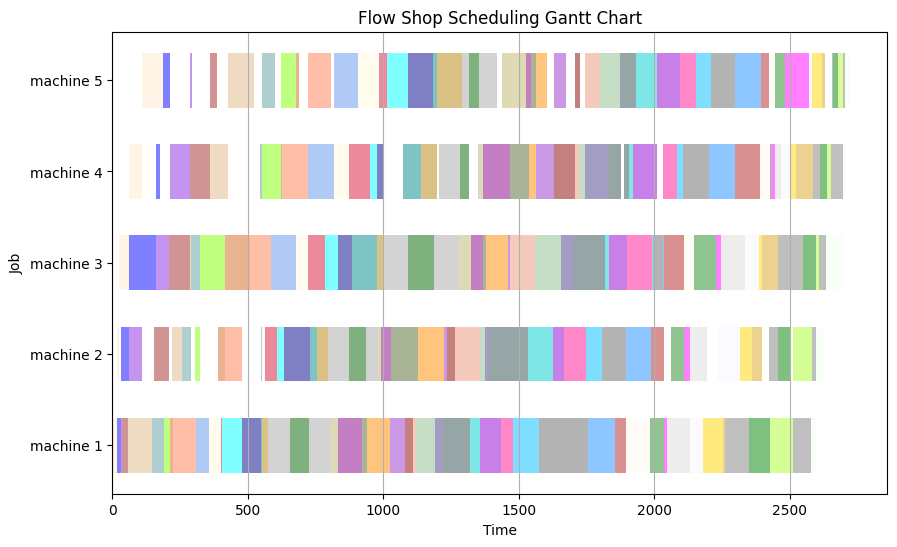

In [11]:
gantt_plotting(processing_times, x_i_j, I_i_k, W_i_k)

In [12]:
# Print the variables
print("Variables:")
num_vars = problem.variables.get_num()
for i in range(num_vars):
    var_name = problem.variables.get_names(i)
    var_lb = problem.variables.get_lower_bounds(i)
    var_ub = problem.variables.get_upper_bounds(i)
    var_type = problem.variables.get_types(i)
    print("Variable {}: Name={}, Lower Bound={}, Upper Bound={}, Type={}".format(i, var_name, var_lb, var_ub,
                                                                                 var_type))

Variables:
Variable 0: Name=x_1_1, Lower Bound=0.0, Upper Bound=1.0, Type=B
Variable 1: Name=x_1_2, Lower Bound=0.0, Upper Bound=1.0, Type=B
Variable 2: Name=x_1_3, Lower Bound=0.0, Upper Bound=1.0, Type=B
Variable 3: Name=x_1_4, Lower Bound=0.0, Upper Bound=1.0, Type=B
Variable 4: Name=x_1_5, Lower Bound=0.0, Upper Bound=1.0, Type=B
Variable 5: Name=x_1_6, Lower Bound=0.0, Upper Bound=1.0, Type=B
Variable 6: Name=x_1_7, Lower Bound=0.0, Upper Bound=1.0, Type=B
Variable 7: Name=x_1_8, Lower Bound=0.0, Upper Bound=1.0, Type=B
Variable 8: Name=x_1_9, Lower Bound=0.0, Upper Bound=1.0, Type=B
Variable 9: Name=x_1_10, Lower Bound=0.0, Upper Bound=1.0, Type=B
Variable 10: Name=x_1_11, Lower Bound=0.0, Upper Bound=1.0, Type=B
Variable 11: Name=x_1_12, Lower Bound=0.0, Upper Bound=1.0, Type=B
Variable 12: Name=x_1_13, Lower Bound=0.0, Upper Bound=1.0, Type=B
Variable 13: Name=x_1_14, Lower Bound=0.0, Upper Bound=1.0, Type=B
Variable 14: Name=x_1_15, Lower Bound=0.0, Upper Bound=1.0, Type=B
Var

In [13]:
print("Constraints:")
for i, constraint in enumerate(problem.linear_constraints.get_rows()):
    print("Constraint {}: {}".format(i, constraint))

variable_indexes = []

for i, constraint in enumerate(problem.linear_constraints.get_rows()):
    indexes = constraint.ind
    variable_indexes.extend(indexes)

# Remove duplicates if needed
variable_indexes = list(set(variable_indexes))

# Get variable values
solution_values = problem.solution.get_values()

# Print the variables and their values
for i, value in enumerate(solution_values):
    var_name = problem.variables.get_names(i)
    var_value = value

# Print the constraints in equation form with variable values
print("\nConstraints:")
for i, constraint in enumerate(problem.linear_constraints.get_rows()):
    indices = constraint.ind
    coefficients = constraint.val
    constant = problem.linear_constraints.get_rhs(i)  # Access the RHS of the constraint
    constraint_eq = ""
    for index, coefficient in zip(indices, coefficients):
        var_name = problem.variables.get_names(index)
        var_value = solution_values[index]  # Get the value of the variable in the solution
        constraint_eq += " {}*{}({}) +".format(coefficient, var_name, var_value)
    constraint_eq = constraint_eq[:-1]  # Remove the trailing '+'
    print("Constraint {}: {} = {}".format(i, constraint_eq, constant))

Constraints:
Constraint 0: SparsePair(ind = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150, 2200, 2250, 2300, 2350, 2400, 2450], val = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
Constraint 1: SparsePair(ind = [1, 51, 101, 151, 201, 251, 301, 351, 401, 451, 501, 551, 601, 651, 701, 751, 801, 851, 901, 951, 1001, 1051, 1101, 1151, 1201, 1251, 1301, 1351, 1401, 1451, 1501, 1551, 1601, 1651, 1701, 1751, 1801, 1851, 1901, 1951, 2001, 2051, 2101, 2151, 2201, 2251, 2301, 2351, 2401, 2451], val = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [14]:
# Print the constraints in equation form with variable values
print("\nConstraints: with 0 times variable removed from equation")
for i, constraint in enumerate(problem.linear_constraints.get_rows()):
    indices = constraint.ind
    coefficients = constraint.val
    constant = problem.linear_constraints.get_rhs(i)  # Access the RHS of the constraint
    constraint_eq = ""
    for index, coefficient in zip(indices, coefficients):
        var_name = problem.variables.get_names(index)
        var_value = solution_values[index]  # Get the value of the variable in the solution
        if var_value != 0:  # Check if the variable value is not zero
            constraint_eq += " {}*{}({}) +".format(coefficient, var_name, var_value)
    if constraint_eq:  # Check if the constraint equation is not empty
        constraint_eq = constraint_eq[:-1]  # Remove the trailing '+'
        print("Constraint {}: {} = {}".format(i, constraint_eq, constant))


Constraints: with 0 times variable removed from equation
Constraint 0:  1.0*x_31_1(1.0)  = 1.0
Constraint 1:  1.0*x_40_2(1.0)  = 1.0
Constraint 2:  1.0*x_39_3(1.0)  = 1.0
Constraint 3:  1.0*x_11_4(1.0)  = 1.0
Constraint 4:  1.0*x_2_5(1.0)  = 1.0
Constraint 5:  1.0*x_38_6(1.0)  = 1.0
Constraint 6:  1.0*x_26_7(1.0)  = 1.0
Constraint 7:  1.0*x_3_8(1.0)  = 1.0
Constraint 8:  1.0*x_45_9(1.0)  = 1.0
Constraint 9:  1.0*x_34_10(1.0)  = 1.0
Constraint 10:  1.0*x_6_11(1.0)  = 1.0
Constraint 11:  1.0*x_18_12(1.0)  = 1.0
Constraint 12:  1.0*x_1_13(1.0)  = 1.0
Constraint 13:  1.0*x_25_14(1.0)  = 1.0
Constraint 14:  1.0*x_41_15(1.0)  = 1.0
Constraint 15:  1.0*x_32_16(1.0)  = 1.0
Constraint 16:  1.0*x_14_17(1.0)  = 1.0
Constraint 17:  1.0*x_21_18(1.0)  = 1.0
Constraint 18:  1.0*x_9_19(1.0)  = 1.0
Constraint 19:  1.0*x_17_20(1.0)  = 1.0
Constraint 20:  1.0*x_43_21(1.0)  = 1.0
Constraint 21:  1.0*x_42_22(1.0)  = 1.0
Constraint 22:  1.0*x_15_23(1.0)  = 1.0
Constraint 23:  1.0*x_46_24(1.0)  = 1.0
Constr

In [15]:
# Record the end time
end_time = time.time()
total_time = end_time - start_time
print(f"Total time to run all cells: {total_time:.2f} seconds")

Total time to run all cells: 3.49 seconds
